# 对抗式生成网络

尽管在教程的大部分时间，我们都在讨论如何进行预测。换句话说，我们使用深度神经网络学习数据到标签的映射。这种类型的学习被称之为判别式学习，就像我们希望能够区分猫的照片和狗的照片所要做的那样。分类器和回归器都是判别式学习的例子。使用反向传播算法进行训练的神经网络颠覆了我们在复杂的大型数据集上进行判别式学习的认知。仅仅在5-6年的时间内，神经网络模型在高分辨图像上的分类准确率就已经从没啥用发展到等同人类水平。之后，我们会继续教授在哪些判别式学习任务上，深度神经网络可以做得非常好。

但是，除了判别式学习，机器学习还有其他的一些任务需要解决。例如，给定一个没有任何标签的大型数据集，我们可能会希望可以学到一个模型能够捕捉这些数据的特征。使用这样的一个模型，我们能够合成出一些数据，它和训练数据的分布是相似的。例如，如果有一个包含了大量人脸照片的数据集，我们希望能够合成一些逼真的图像，它们看起来就像是从数据集中挑出来的一样。这种学习我们称之为生成式学习。

直到最近之前，我们都还没有一种方法可以合成出这种类似于真实照片的图像。但是深度神经网络在判别式模型上的成功为其开启了新的可能。在过去三年的发展中，那些通常不被认为是监督学习的任务在应用了判别式神经网络模型之后，问题得到了很好的解决。就像RNN言语模型作为作为判别式模型通常被用来预测字符，但是现在它也可以被训练成生成式模型。

在2004年，一个叫Ian Goodfellow的年轻研究员介绍了一种巧妙的新方法[Generative Adversarial Networks (GANs)](https://arxiv.org/abs/1406.2661)，这个方法利用判别式模型的力量以得到一个好的生成式模型。GANs的效果非常惊人，你很可能以前已经看到过这些生成的图像。例如使用GANs可以生成一系列假的卧室图像（如下图所示），这个工作由[Radford等人在2015年完成](https://arxiv.org/pdf/1511.06434.pdf)。

![](../img/fake_bedrooms.png)

GAN的核心思路在于，如果我们不能够区分假的生成数据和真实的数据，那么生成模型就是好的。在统计中，这被称作双样本测试，它用来回答数据$X = \{x_1, \ldots x_n\}$和 $X' = \{x_1', \ldots x_n'\}$是否来自同一分布。大多数统计论文和GAN的主要差别在于后者是一种建设性的方法。换句话说，它并非要训练一个模型回答说，“嘿，这两个数据集看起来不像是来自于同一个数据分布”，它是要利用双样本测试来为生成模型提供训练依据。这种测试方法使我们可以不断的改进数据生成器，直到它能够生成一些类似于真实数据的东西。至少，它需要能够欺骗分类器，如果我们的深度神经网络是一种很好的分类器的话。

正如你看到的那样，一个GAN由两部分组成。首先，我们需要一个设备（就像深度神经网络，但它实际上可以是任何东西，例如游戏渲染引擎）能够产生一些看起来像真的一样的数据。如果我们处理的使图像数据，那么它需要能够生成图像。如果我们处理的是语音，那么它需要生成音频序列。我们将其称之为生成网络。其次，我们需要的第二个部件是判别网络。它尝试将虚假数据和真实数据区分开。生成网络尝试愚弄判别网络；同时，判别网络逐渐适应新的虚假数据；这又反过来用来改善生成网络的性能。两个网络就这样相互竞争，不断迭代。


**生成器**
* 从例如说正态分布( $z \sim \mathcal{N}(0,1)$ )的随机数据中获得一些参数。
* 应用一个函数 $f$ 以得到 $x' = G(u,w)$
* 计算$w$的梯度以最小化$\log p(y = \mathrm{fake}|x')$ 

**判别器**
* 提升二分类函数$f$的准确率，例如分别通过最大化假数据$x'$和真实数据$x$的函数：$\log p(y=\mathrm{fake}|x')$ and $\log p(y=\mathrm{true}|x)$。


![](../img/simple-gan.png)

简而言之，有两个优化在同时运行；当优化达到了平衡后，优化就会终止。在如何修改基础设置上有很多的技巧和细节需要处理。例如说，我们可以在有辅助信息的情况进行训练，这就得到了cGAN（conditional Generative Adversarial Networks，条件对抗式生成模型）。如果改变我们区分真实数据和假数据的方式，我们可以得到wGAN (Wasserstein GAN)和 kernel-inspired GANs。或者我们还可以改变观察对象的层次，例如说伪造的数据在纹理上看起来可能很真实，但在更高层次上则不然；反之亦然。

许多应用处理的都是图片内容。但是由于在笔记本电脑上运行Jupyter notebook来解决此类问题会花费太多的时间，我们将拟合一个更为简单的分布作为演示。我们会展示如何使用GANs来构建世界上最低效的高斯分布参数估计。让我们开始吧。

In [1]:
from __future__ import print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn
import numpy as np

ctx = mx.cpu()

## 生成一些‘真实’的数据

这是一个比较烂的例子，我们只是简单地从高斯分布中抽取了一些数据。同时我们需要设定一下进行计算的context。

In [2]:
X = nd.random_normal(shape=(1000, 2))
A = nd.array([[1, 2], [-0.1, 0.5]])
b = nd.array([1, 2])
X = nd.dot(X, A) + b
Y = nd.ones(shape=(1000, 1))

# and stick them into an iterator
batch_size = 4
train_data = mx.io.NDArrayIter(X, Y, batch_size, shuffle=True)

让我们看一下得到了什么。这应该是一个有少许随机偏移的高斯分布，它的均值为$b$，协方差矩阵为$A^\top A$。

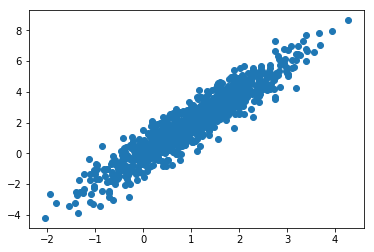

The covariance matrix is

[[ 1.00999999  1.95000005]
 [ 1.95000005  4.25      ]]
<NDArray 2x2 @cpu(0)>


In [3]:
plt.scatter(X[:,0].asnumpy(), X[:,1].asnumpy())
plt.show()
print("The covariance matrix is")
print(nd.dot(A.T, A))

## 设计网络

接下来我们需要设计如何进行数据的生成。我们的生成模型可能会是最简单的神经网络，一个单层的线性模型。因为我们要使用这个线性模型来生成高斯数据，因此，它只需要学习一些参数让它的效果变得更好而已。而对于判别模型来说，我们需要它具有稍强一点的判别能力。在这里，我们使用了三层的MLP以使事情变得更有趣一些。

最酷的地方在于，我们拥有两个不同的神经网络，它们每一个都拥有自己的梯度，优化器，损失等等我们可以进行优化的东西。

In [4]:
# build the generator
netG = nn.Sequential()
with netG.name_scope():
    netG.add(nn.Dense(2))

# build the discriminator (with 5 and 3 hidden units respectively)
netD = nn.Sequential()
with netD.name_scope():
    netD.add(nn.Dense(5, activation='tanh'))
    netD.add(nn.Dense(3, activation='tanh'))
    netD.add(nn.Dense(2))

# loss
loss = gluon.loss.SoftmaxCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': 0.01})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': 0.05})

## 设定训练参数

我们将在数据上迭代几次。为了让生活简单点，我们需要几个变量来表示这些数据。

In [5]:
real_label = mx.nd.ones((batch_size,), ctx=ctx)
fake_label = mx.nd.zeros((batch_size,), ctx=ctx)
metric = mx.metric.Accuracy()

# set up logging
from datetime import datetime
import os
import time

## 训练


binary training acc at epoch 0: accuracy=0.764500
time: 5.838877


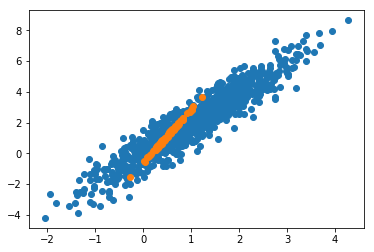


binary training acc at epoch 1: accuracy=0.639000
time: 6.052228


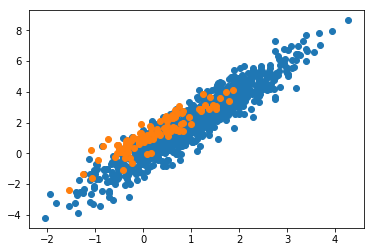


binary training acc at epoch 2: accuracy=0.551000
time: 5.773329


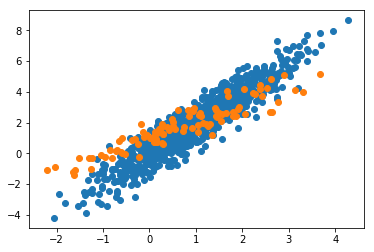


binary training acc at epoch 3: accuracy=0.522000
time: 5.613472


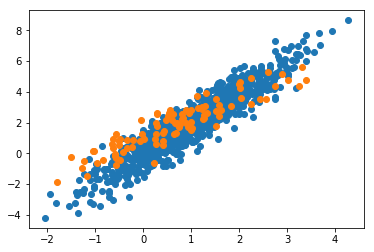


binary training acc at epoch 4: accuracy=0.498000
time: 6.069607


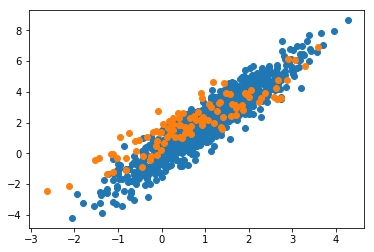


binary training acc at epoch 5: accuracy=0.496500
time: 5.800509


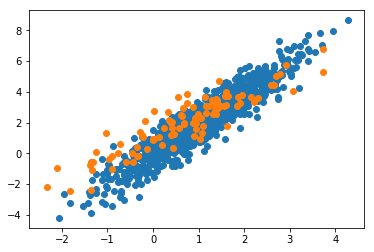


binary training acc at epoch 6: accuracy=0.498500
time: 5.982538


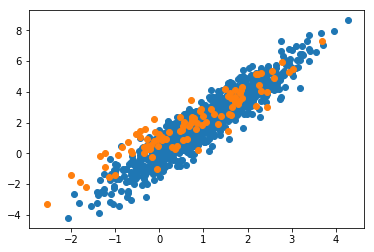


binary training acc at epoch 7: accuracy=0.515500
time: 6.017519


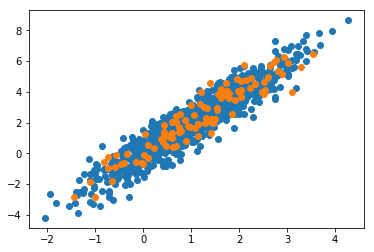


binary training acc at epoch 8: accuracy=0.500000
time: 6.143714


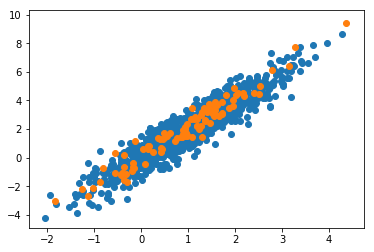


binary training acc at epoch 9: accuracy=0.499000
time: 6.123487


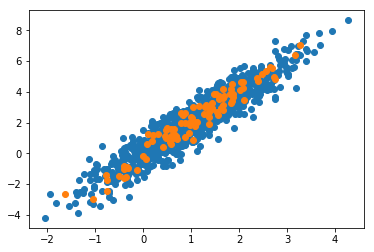

In [6]:
stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
for epoch in range(10):
    tic = time.time()
    train_data.reset()
    for i, batch in enumerate(train_data):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real_t
        data = batch.data[0].as_in_context(ctx)
        noise = nd.random_normal(shape=(batch_size, 2), ctx=ctx)

        with autograd.record():
            real_output = netD(data)
            errD_real = loss(real_output, real_label)
            
            fake = netG(noise)
            fake_output = netD(fake.detach())
            errD_fake = loss(fake_output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()

        trainerD.step(batch_size)
        metric.update([real_label,], [real_output,])
        metric.update([fake_label,], [fake_output,])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            output = netD(fake)
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch_size)

    name, acc = metric.get()
    metric.reset()
    print('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    print('time: %f' % (time.time() - tic))
    noise = nd.random_normal(shape=(100, 2), ctx=ctx)
    fake = netG(noise)
    plt.scatter(X[:,0].asnumpy(), X[:,1].asnumpy())
    plt.scatter(fake[:,0].asnumpy(), fake[:,1].asnumpy())
    plt.show()

## 检查输出

让我们生成一些假的数据，看看他们是不是像真的一样。

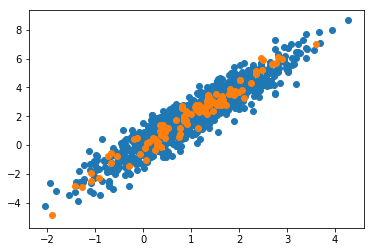

In [7]:
noise = mx.nd.random_normal(shape=(100, 2), ctx=ctx)
fake = netG(noise)

plt.scatter(X[:,0].asnumpy(), X[:,1].asnumpy())
plt.scatter(fake[:,0].asnumpy(), fake[:,1].asnumpy())
plt.show()

## 总结

注意一下，为了融合得当，我们必须非常小心的调节学习率。另外对于高斯分布而言，这些结果是相当平庸的；相比之下，一个简单的均值和协方差估计就能够很好的实现上述功能。但是，当我们并不知道真实的数据分布是什么的时候，这种方式就能够非常好的模拟相应的数据。需要注意的是，这种方式非常依赖判别模型的能力。如果判别模型非常的弱，那么生成的数据将会远离真实的数据。例如，在这个例子中，模型在方差较小的方向上生成数据就有些困难。总之，这并不容易设计和实现。(set and forget?)这里给出一些资源，其中相关人员展示了一些如何训练GAN的经验性技巧[Soumith Chintala's handy list of tricks](https://github.com/soumith/ganhacks)。